In [ ]:
# Importamos las librerias necesarias a nuestro analisis y modelo de clasificacion 
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings 
import itertools
import matplotlib
import matplotlib.dates as md
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['text.color'] = 'k'



In [ ]:
#Conectamos nuestro entorno al drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Leemos nuestro dataset a partir del fichero csv 
path= "/content/drive/MyDrive/Colab Notebooks/DATOS_COMPLETOS.CSV"
Df = pd.read_csv(path, delimiter=";", parse_dates=['DateObserved'])

In [ ]:
Df.head()

,Id,Machine,DateStr,DateObserved,H,V,C
0,921880,Batidora,01/09/2018 13:39:16,2018-09-01 13:39:16,0.18,0.14,0.1
1,921881,Batidora,01/09/2018 13:39:46,2018-09-01 13:39:46,0.17,0.15,0.1
2,921882,Batidora,01/09/2018 13:40:15,2018-09-01 13:40:15,0.17,0.17,0.1
3,921883,Batidora,01/09/2018 13:42:56,2018-09-01 13:42:56,0.17,0.16,0.1
4,921884,Batidora,01/09/2018 13:43:26,2018-09-01 13:43:26,0.17,0.19,0.1


In [ ]:
#Guardamos las columna que nos interesan y indexamos nuestro dataset
batidora = Df.loc[Df['Machine'] == 'Batidora']
cols = ['Id','DateStr','Machine']
batidora.drop(cols, axis=1, inplace=True) 
#batidora = batidora.sort_values('DateObserved')
batidora

,DateObserved,H,V,C
0,2018-09-01 13:39:16,0.18,0.14,0.1
1,2018-09-01 13:39:46,0.17,0.15,0.1
2,2018-09-01 13:40:15,0.17,0.17,0.1
3,2018-09-01 13:42:56,0.17,0.16,0.1
4,2018-09-01 13:43:26,0.17,0.19,0.1
...,...,...,...,...
700621,2019-04-30 12:28:48,0.22,0.21,0.1
700622,2019-04-30 12:29:16,0.25,0.23,0.1
700623,2019-04-30 12:29:45,0.24,0.22,0.1
700624,2019-04-30 12:30:13,0.23,0.23,0.1


In [ ]:
#Comprobamos si hay valores nullos dentro de nuestro dataset en cada columnas
batidora.isnull().sum()

DateObserved     0
H               28
V                0
C                7
dtype: int64

In [ ]:
Df = batidora 
Df.head()

,DateObserved,H,V,C
0,2018-09-01 13:39:16,0.18,0.14,0.1
1,2018-09-01 13:39:46,0.17,0.15,0.1
2,2018-09-01 13:40:15,0.17,0.17,0.1
3,2018-09-01 13:42:56,0.17,0.16,0.1
4,2018-09-01 13:43:26,0.17,0.19,0.1


In [ ]:
#Ploteamos nuestro dataframe en funcion del tiempo 
fig = px.line(Df[:500],x='DateObserved', y = Df.columns,
              hover_data ={ 'DateObserved':"|c%"},
              title = 'custom tick labels')
fig.update_xaxes(
    dtick = "M1",
    tickformat = "%b\n%Y")
fig.show()

Este grafico nos permite ver la evolucion de ls diferentes parametros a lo largo del tiempo de las 500 primeras observaciones.Primero podemos ver que en este rango de tiempo el corriente casi no evolua. Solo se nota dos evoluciones una al principio positivamente y la otra casi en el fin negativamente. Podemos observar tambien las diferencias de nivel entre los dos tipos de vibraciones que hay.Se nota que las vibraciones horizontales son casi siempre por encima que las verticales

In [ ]:
#Creamos un nuevo dataset con observaciones cada 15 minutos. 
batidora = batidora.set_index('DateObserved')
batidoraresample15m = batidora.resample('15 min').mean()
batidoraresample15m['H'].fillna(batidoraresample15m['H'].min(),inplace=True)
batidoraresample15m['V'].fillna(batidoraresample15m['V'].min(),inplace=True)
batidoraresample15m['C'].fillna(batidoraresample15m['C'].min(),inplace=True)
batidoraresample15m.head()

,H,V,C
DateObserved,,,
2018-09-01 13:30:00,0.177500,0.166250,0.100000
2018-09-01 13:45:00,0.181667,0.169000,0.100000
2018-09-01 14:00:00,0.183871,0.166452,0.100323
2018-09-01 14:15:00,0.190323,0.170968,0.102581
2018-09-01 14:30:00,0.195806,0.183871,0.100000


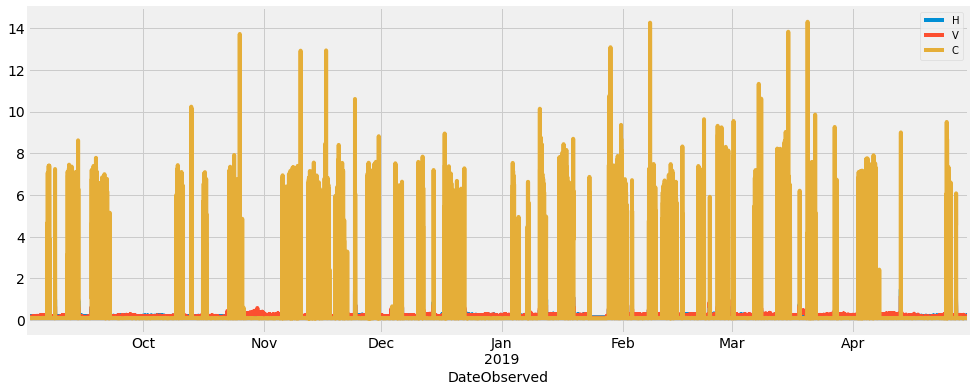

In [ ]:
batidoraresample15m.plot(figsize=(15,6))

En este grafico podemos observar la distribucion de los valores de los diferentes parametros de la batidora con datos recibidos cada 15 miutos. Podemos constatar varios estados del corriente de la batiora con momentos de actividad fuertes, momentos de pasa y momentos de inactividad.En este grafico mismo se puede ver en pequeño la evolucion de las vibraciones pero no sufisamente para analzarlas.

In [ ]:
##Creamos un nuevo dataset con observaciones cada 5 minutos
batidoraresample5m = batidora.resample('5 min').mean()
batidoraresample5m['H'].fillna(batidoraresample15m['H'].min(),inplace=True)
batidoraresample5m['V'].fillna(batidoraresample15m['V'].min(),inplace=True)
batidoraresample5m['C'].fillna(batidoraresample15m['C'].min(),inplace=True)
batidoraresample5m.head()

,H,V,C
DateObserved,,,
2018-09-01 13:35:00,0.175000,0.145000,0.1
2018-09-01 13:40:00,0.178333,0.173333,0.1
2018-09-01 13:45:00,0.185000,0.162000,0.1
2018-09-01 13:50:00,0.178000,0.174000,0.1
2018-09-01 13:55:00,0.182000,0.171000,0.1


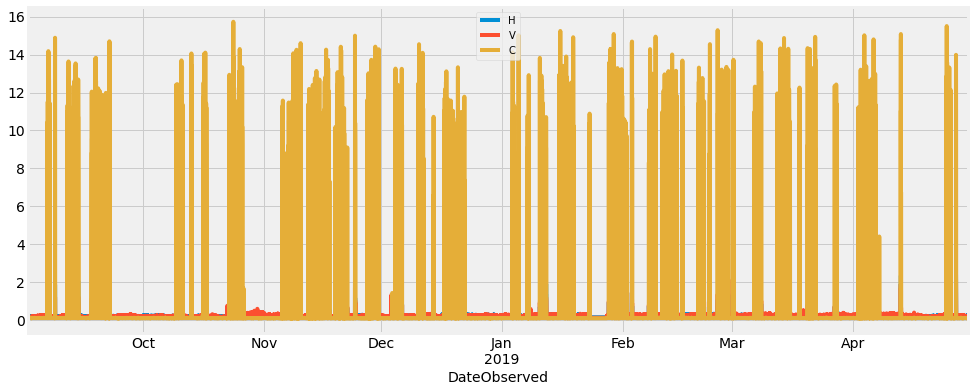

In [ ]:
batidoraresample5m.plot(figsize=(15,6))

En este grafico podemos observar la distribucion de los valores de los diferentes parametros de la batidora con datos recibidos cada 5 miutos. 
Comparado al grafico con datos recibidos cada 15 minutos vemos una mayor frequencia y mas datos debido a su configuracion. Podemos constatar varios estados del corriente de la batiora con momentos de actividad fuertes, momentos de pasa y momentos de inactividad.En este grafico mismo se puede ver en pequeño la evolucion de las vibraciones pero no sufisamente para analzarlas.

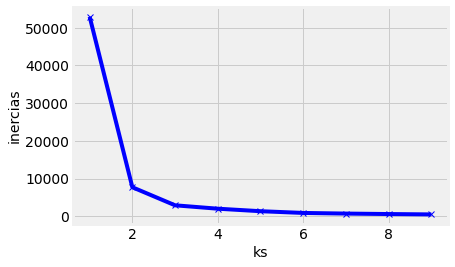

In [ ]:
#Calculamos el mejor numero de cluser posible a partir de la regla del codo 
data = batidoraresample15m[['H','V','C']]
inercias = []
for k in range(1,10):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(data)
  inercias.append(kmeans.inertia_)
plt.plot(range(1,10), inercias, 'bx-')
plt.xlabel('ks')
plt.ylabel('inercias')
plt.show()


A partir de la curva de Elbrow, podemos observar que la grafica se nivela despues de 4 grupos. Esto significa que la adición de mas grupos no explica mucho mas la varianza en nuestra variable relevante. 

In [ ]:
#fiteamos nuestro dataset nuestras variables (x) como el target(y): variable predictoria
X = batidoraresample15m[['H','V','C']]
inercias = []
km = KMeans(n_clusters=4)
km.fit(X)
y_kmeans = km.predict(X)
labels = km.labels_


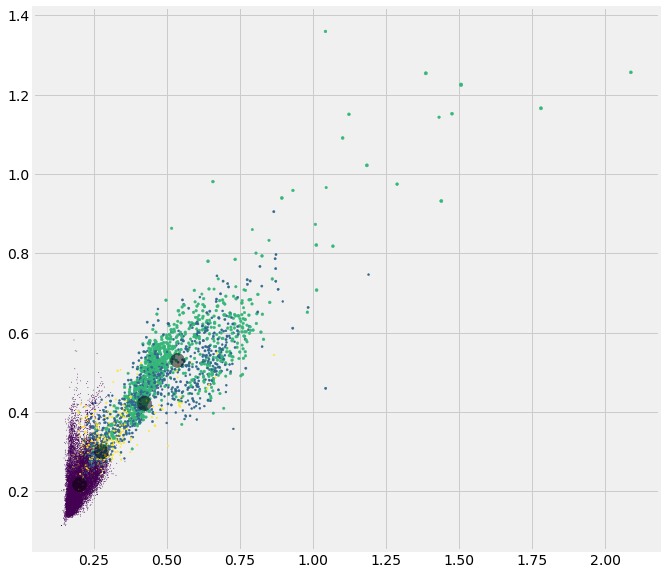

In [ ]:
#ploteamos nuestro dataset despues de haber apliacado el modelo kmeans  en 2D
fig = plt.figure(1,figsize=(10,10))
colors=['r','g','b','y','c','m']
#fig,ax = plt.subplot()
#ax.scatter(X.iloc[:, 0], X.iloc[:,1], X.iloc[:,2], c=labels.astype(np.float), edgecolor="k" )

plt.scatter(X.iloc[:, 0], X.iloc[:,1], X.iloc[:,2], c = y_kmeans)
centers = km.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c="black", s=200, alpha = 0.5);


Como dicho anteriormente, el numuero de grupos mas significativo es de 4. POdemos observar los centroides de nuestro cuatros clusters. El primero alreador de del valor 0.20(purple) el segundo : 0.26(yellow), el tercero(blue): 0.40 y el ultimo (green)

No handles with labels found to put in legend.


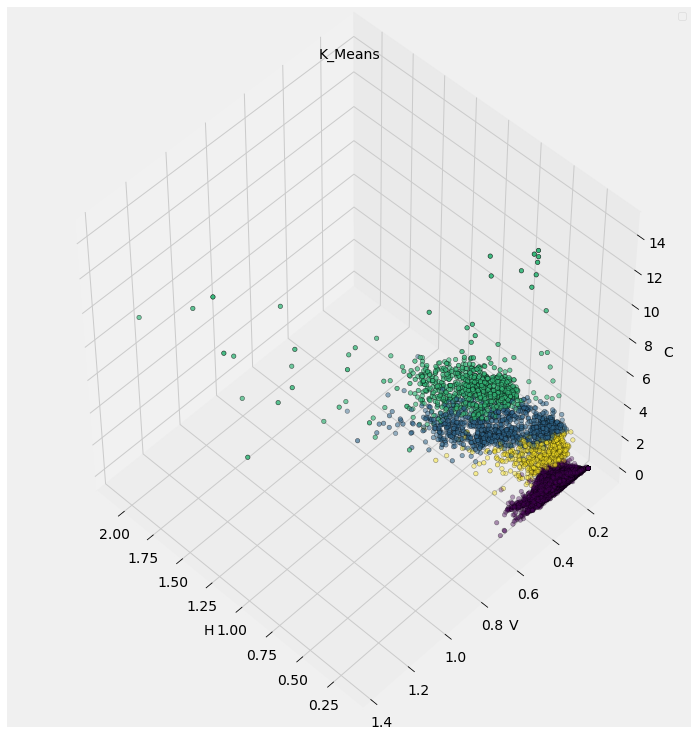

In [ ]:
#ploteamos nuestro dataset despues de haber apliacado el modelo kmeans esta vez en 3D
fig = plt.figure(1,figsize=(10,10))
ax = Axes3D(fig,rect=[0,0,0.95,1],elev=48,azim=134)
ax.scatter(X.iloc[:,0],X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel('H')
ax.set_ylabel('V')
ax.set_zlabel('C')
plt.legend()
plt.title('K_Means',fontsize=14);


Aqui de la misma forma podemos observar nuestros cuatros clusters este vez visible en 3D y entonces en varios angulos. Vemos que con este tipo de grafico se hace mejor la distinccion entre los diferentes grupos. 

In [ ]:
#Entrenamos nuestro modelo 
data = X[['H','V','C']]
resultado = X
kmeans = KMeans(n_clusters=4).fit(data)
centers = kmeans.cluster_centers_
resultado['cluster']= kmeans.predict(data)
resultado['DateObserved']= X.index
resultado.index = data.index
resultado['cluster'].value_counts()

0    20560
2     1181
1      819
3      573
Name: cluster, dtype: int64

In [ ]:
resultado.head()

,H,V,C,cluster,DateObserved
DateObserved,,,,,
2018-09-01 13:30:00,0.177500,0.166250,0.100000,0,2018-09-01 13:30:00
2018-09-01 13:45:00,0.181667,0.169000,0.100000,0,2018-09-01 13:45:00
2018-09-01 14:00:00,0.183871,0.166452,0.100323,0,2018-09-01 14:00:00
2018-09-01 14:15:00,0.190323,0.170968,0.102581,0,2018-09-01 14:15:00
2018-09-01 14:30:00,0.195806,0.183871,0.100000,0,2018-09-01 14:30:00


In [ ]:
#Transformación de los datos
kmeans.transform(data)

array([[0.05543028, 6.69554436, 3.86085272, 1.92264667],
       [0.05133944, 6.69517424, 3.86040922, 1.92225115],
       [0.05304221, 6.69487431, 3.86011936, 1.92200447],
       ...,
       [0.02467815, 6.68895398, 3.85347696, 1.91624811],
       [0.03789138, 6.68577998, 3.85020353, 1.91339824],
       [0.04672207, 6.68889491, 3.85319811, 1.91673845]])

In [ ]:
#definimos los criterios de outliers dentro de nuestro modelo
outliers_fraction = 0.01
distances = (kmeans.transform(data))
resultado['distance']= kmeans.transform(data)[:,0]
resultado['anomaly1'] = (resultado['distance'] >= outliers_fraction).astype(int)
resultado.head(10)

,H,V,C,cluster,DateObserved,distance,anomaly1
DateObserved,,,,,,,
2018-09-01 13:30:00,0.177500,0.166250,0.100000,0,2018-09-01 13:30:00,0.055430,1
2018-09-01 13:45:00,0.181667,0.169000,0.100000,0,2018-09-01 13:45:00,0.051339,1
2018-09-01 14:00:00,0.183871,0.166452,0.100323,0,2018-09-01 14:00:00,0.053042,1
2018-09-01 14:15:00,0.190323,0.170968,0.102581,0,2018-09-01 14:15:00,0.047061,1
2018-09-01 14:30:00,0.195806,0.183871,0.100000,0,2018-09-01 14:30:00,0.033551,1
2018-09-01 14:45:00,0.199667,0.175000,0.100000,0,2018-09-01 14:45:00,0.042225,1
2018-09-01 15:00:00,0.190645,0.177742,0.100000,0,2018-09-01 15:00:00,0.040423,1
2018-09-01 15:15:00,0.183548,0.173548,0.100000,0,2018-09-01 15:15:00,0.046427,1
2018-09-01 15:30:00,0.185161,0.174839,0.100000,0,2018-09-01 15:30:00,0.044681,1


In [ ]:
#contamos los datos encontrado como outlier o anomalias en nuestro modelo
resultado['anomaly1'].value_counts()

1    22591
0      542
Name: anomaly1, dtype: int64

podemos observar que hay 542 datos outliers sobre 23133.
Es una cantidad no negligable de outliers. 

In [ ]:
#esalamos nuestro datos a partir del MinMaxScaler y definemos los diferentes niveles de resuldatos (low,medium,high)
scaler = MinMaxScaler(feature_range=(0,1))
resultado['probability'] = scaler.fit_transform(resultado[['distance']])*100
resultado['level']='low'
resultado['level']=np.where(resultado['probability']>=50, 'medium','low')
resultado['level']=np.where(resultado['probability']>=60, 'high',resultado['level'])
resultado['level']=np.where(resultado['probability']>=75, 'medium',resultado['level'])

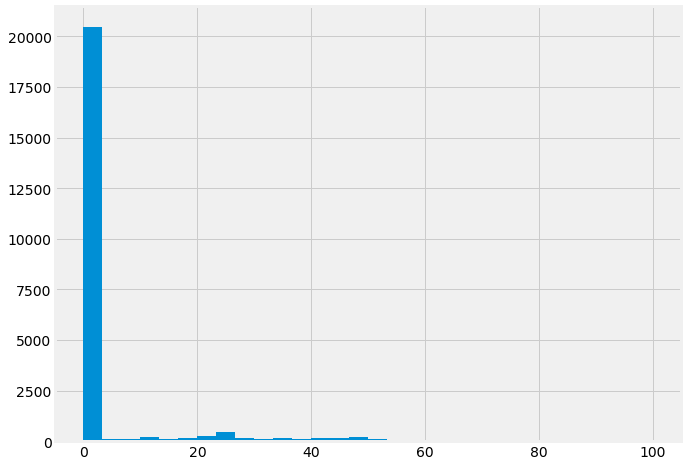

In [ ]:
resultado['probability'].hist(bins=30, grid=True, figsize=(10,8))

In [ ]:
#analizamos las proporciones de datos que tenemos en cada percentiles 
resultado['probability'].describe(percentiles=(.1,.25,.5,.75,.9,.95,0.99))

count    23133.000000
mean         3.721269
std         10.525017
min          0.000000
10%          0.120938
25%          0.202125
50%          0.331933
75%          0.530539
90%         12.805408
95%         29.132259
99%         49.250953
max        100.000000
Name: probability, dtype: float64

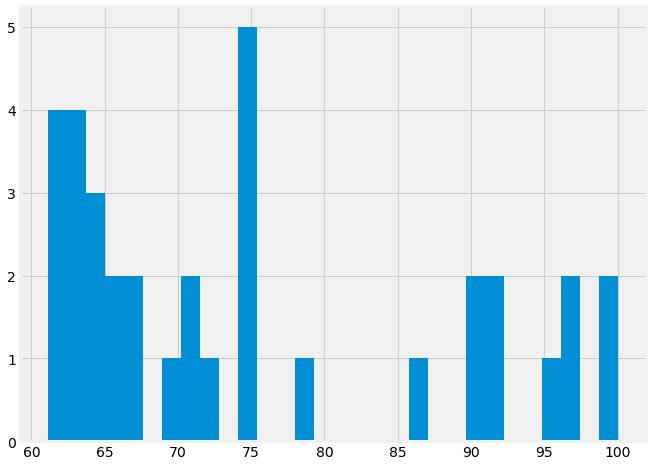

In [ ]:
#Ploteamos la distribucion de las anomalias 
criticas_altas = resultado.loc[(resultado['anomaly1']==1) & (resultado['probability']>=61)]
criticas_altas['probability'].hist(bins=30, grid=True, figsize=(10,8))


Aqui tenemos un grafico que nos enseña las anomalias que tienen un nivel de probabilidad por encima de 60%. POdemos ver que la mayoria de estas anomalias se encuentran entre 60 y 65. Luego tenemos un pico de valores que se acercan a 75%.

In [ ]:
#Comprobamos el nivel de presencia de las anomalias 
criticas_altas['probability'].describe(percentiles=(.1,.25,.5,.75,.9,.95,0.99))

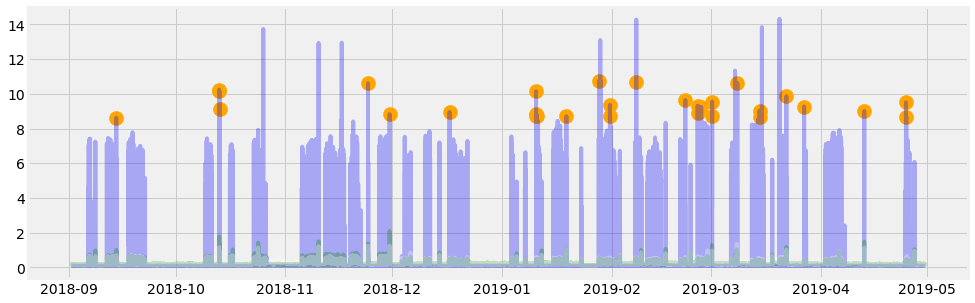

In [ ]:
#Ploteamos las anomalias al nivel de corriente
fig, ax = plt.subplots(figsize=(15,5))

criticas = resultado.loc[(resultado['anomaly1']==1) & (resultado['level']=='critical')]
altas = resultado.loc[(resultado['anomaly1']==1) & (resultado['level']=='high')]
ax.scatter(criticas['DateObserved'],criticas['C'], color='red', s=200)
ax.scatter(altas['DateObserved'],altas['C'], color='orange', s=200)
ax.plot(resultado['DateObserved'],resultado['C'], color='blue', alpha=0.3)
ax.plot(resultado['DateObserved'],resultado['H'], color='green', alpha=0.3)
ax.plot(resultado['DateObserved'],resultado['V'], color='white', alpha=0.3)
plt.show()

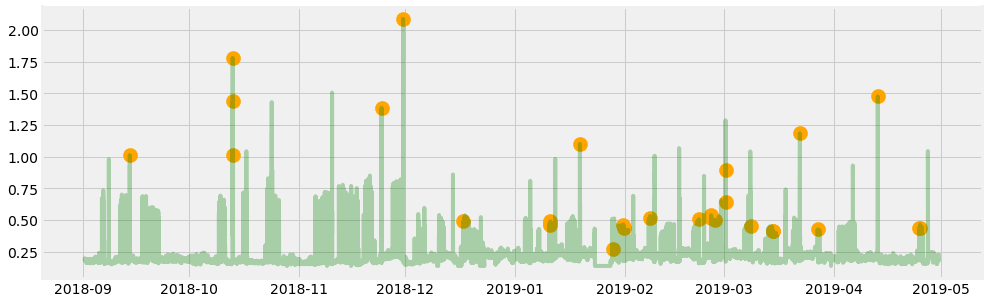

In [ ]:
#Ploteamos los anomalias de vibracion horizontales
fig, ax = plt.subplots(figsize=(15,5))

criticas = resultado.loc[(resultado['anomaly1']==1) & (resultado['level']=='critical')]
altas = resultado.loc[(resultado['anomaly1']==1) & (resultado['level']=='high')]
ax.scatter(criticas['DateObserved'],criticas['H'], color='red', s=200)
ax.scatter(altas['DateObserved'],altas['H'], color='orange', s=200)
#ax.plot(resultado['DateObserved'],resultado['C'], color='blue', alpha=0.3)
ax.plot(resultado['DateObserved'],resultado['H'], color='green', alpha=0.3)
#ax.plot(resultado['DateObserved'],resultado['V'], color='white', alpha=0.3)
plt.show()

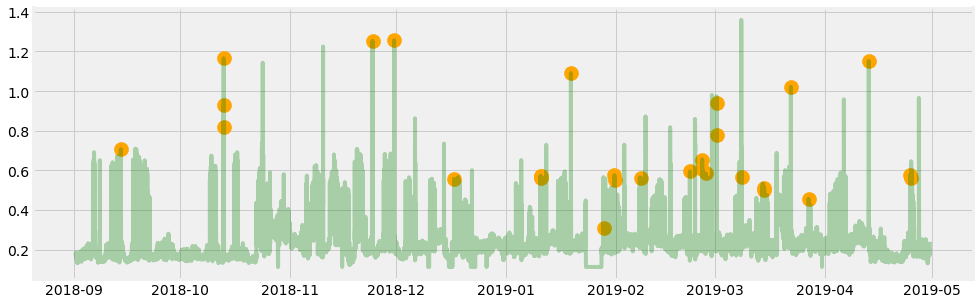

In [ ]:
#Ploteamos los anomalias de vibracion horizontales
fig, ax = plt.subplots(figsize=(15,5))

criticas = resultado.loc[(resultado['anomaly1']==1) & (resultado['level']=='critical')]
altas = resultado.loc[(resultado['anomaly1']==1) & (resultado['level']=='high')]
ax.scatter(criticas['DateObserved'],criticas['V'], color='red', s=200)
ax.scatter(altas['DateObserved'],altas['V'], color='orange', s=200)
#ax.plot(resultado['DateObserved'],resultado['C'], color='blue', alpha=0.3)
#ax.plot(resultado['DateObserved'],resultado['H'], color='green', alpha=0.3)
ax.plot(resultado['DateObserved'],resultado['V'], color='green', alpha=0.3)
plt.show()

In [ ]:
#Creemos un subset con las anomalias dichos importantes con un nivel critico
importantes = resultado.loc[(resultado['anomaly1']==1) & (resultado['probability']>=60)]
importantes.head(20)


,H,V,C,cluster,DateObserved,distance,anomaly1,probability,level
DateObserved,,,,,,,,,
2018-09-14 07:00:00,1.012258,0.707097,8.626774,1,2018-09-14 07:00:00,8.577205,1,60.328249,high
2018-10-13 07:30:00,1.780000,1.165484,10.243226,1,2018-10-13 07:30:00,10.307149,1,72.497763,high
2018-10-13 08:30:00,1.439000,0.931667,10.160000,1,2018-10-13 08:30:00,10.159021,1,71.455739,high
2018-10-13 10:00:00,1.011290,0.820645,9.100000,1,2018-10-13 10:00:00,9.054448,1,63.685475,high
2018-10-25 18:00:00,0.525000,0.446000,13.732333,1,2018-10-25 18:00:00,13.635895,1,95.914263,medium
2018-11-10 08:30:00,1.506452,1.224839,12.930645,1,2018-11-10 08:30:00,12.934132,1,90.977624,medium
2018-11-16 21:30:00,0.393437,0.369375,12.943437,1,2018-11-16 21:30:00,12.843557,1,90.340461,medium
2018-11-24 07:15:00,1.385938,1.253750,10.612813,1,2018-11-24 07:15:00,10.628008,1,74.754887,high
2018-11-30 09:30:00,2.087742,1.256129,8.825484,1,2018-11-30 09:30:00,8.985570,1,63.200945,high


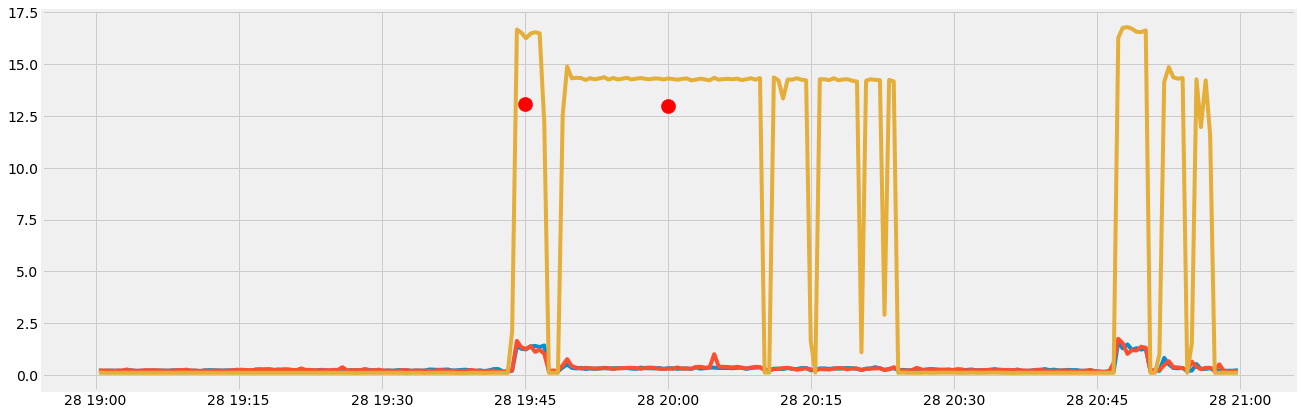

In [ ]:
#Ploteamos las anomalias al nivel del corriente de la batidora en una frenja horaria definida
Dfsub = batidora.loc['2019-01-28 19' : '2019-01-28 20']
anomalias = importantes.loc['2019-01-28 19' : '2019-01-28 20']

fig, ax = plt.subplots(figsize=(20,7))
x = Dfsub.index
ax.scatter(anomalias['DateObserved'],anomalias['C'], color='red', s=200)
ax.plot(x,Dfsub['H'])
ax.plot(x,Dfsub['V'])
ax.plot(x,Dfsub['C'])
plt.show()

Aqui tenemos un grafico de la evolucion del corriente de la batidora entre el 28 de enero 2019 desde las 7 hasta las 9. Este grafico nos permite detectar las anomalias a un nivel critico en este horario. Podemos observar dos anomalias indicado por dos puntos rojos que no siguen el comportamiento normal del corriente de la batidora. 

In [ ]:
data = { 'H':[10],
         'V':[10],
         'C':[10],
        'DateObserved':
       }
new_data = data.iloc[:1]
resultad = new_data
#Calculo de distancia 
distancia = kmeans.transform(new_data)[:0]
#calculo de cluster
cluster = kmeans.predict(new_data)
resultado['cluster'] = cluster
resultado['distancia'] = distancia
#identificación de anomalia
resultado['anomaly1'] = (resultado['distancia']>=outliers_fraction).astype(int)
#escalo la distancia de 0 a 1 para obtener la importancia relativa
scaler = MinMaxScaler(feature_range=(0,1))
resultado['probability'] = scaler.fit_transform(resultado[['distancia']])*100
#Establezer la importancia en funcion de la probabilidad 
resultado['level']= "low"
resultado['level']= np.where(resultado['probability']>=50, "medium",'low')
resultado['level'] = np.where(resultado['probability']>=60, "high",resultado['level'])
resultado['level'] = np.where(resultado['probability']>=75, "critical",resultado['level'])
resultado.head(10)

SyntaxError: ignored

CONCLUSION

Las anomalías detectadas en la tendencia de la corriente pueden deberse a una sobrecarga de la batería. Esta sobrecarga de la batería provocaría una inversión de las vibraciones que normalmente deberían ser horizontales y que, en caso de alta intensidad de corriente, se convierten en verticales (de ahí las anomalías observadas en las vibraciones).